In [1]:
# pip install datasets umap-learn pycddlib dask dask-expr cvxopt
from datasets import load_dataset
from datasets import Dataset
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import numpy as np

from numba import jit

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report

from scipy.spatial import ConvexHull

import polytope as pc

from pypoman import compute_polytope_vertices
from pypoman import plot_polygon, project_polytope
from pypoman import compute_polytope_halfspaces

import cdd

from umap import UMAP

import manifold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Dataset hat 473800776 Zeilen und die Spalten: 'vertices', 'vertex_count', 'facet_count', 'point_count', 'dual_point_count', 'h11', 'h12', 'euler_characteristic'.

In [2]:
#dataset = load_dataset("calabi-yau-data/polytopes-4d", cache_dir="C:/Users/esultano/git/polytopes/data/huggingface", split="full").shuffle(seed=42)
#print("Verfügbare Aufteilungen:", dataset)

In [25]:
vertex_count_data = load_dataset(
    "calabi-yau-data/polytopes-4d",
    cache_dir="C:/Users/esultano/git/polytopes/data/huggingface",
    split="full"
).select_columns(["vertex_count"])

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

In [26]:
# Determine vertex counts (using batches)
batch_size = 100_000
vertex_counts = pd.Series(dtype=int)
rows = len(vertex_count_data)

# Process in chunks using .select()
for start_idx in range(0, rows, batch_size):
    end_idx = min(start_idx + batch_size, rows)
    batch = vertex_count_data.select(range(start_idx, end_idx)).to_pandas()
    vertex_counts = vertex_counts.add(batch["vertex_count"].value_counts(), fill_value=0)

# Convert to integers for cleaner results
vertex_counts = vertex_counts.astype(int)

# Display results
vertex_counts_sorted = vertex_counts.sort_index()
print(vertex_counts_sorted)

vertex_count
5         1561
6        24189
7       177446
8       834638
9      2867955
10     7725801
11    16608387
12    29270253
13    43458000
14    56060584
15    64085869
16    65615931
17    59972682
18    48703033
19    34847821
20    21913680
21    12070919
22     5826221
23     2450720
24      898929
25      284696
26       78468
27       18417
28        3781
29         647
30         114
31          23
32           8
33           2
36           1
dtype: int32


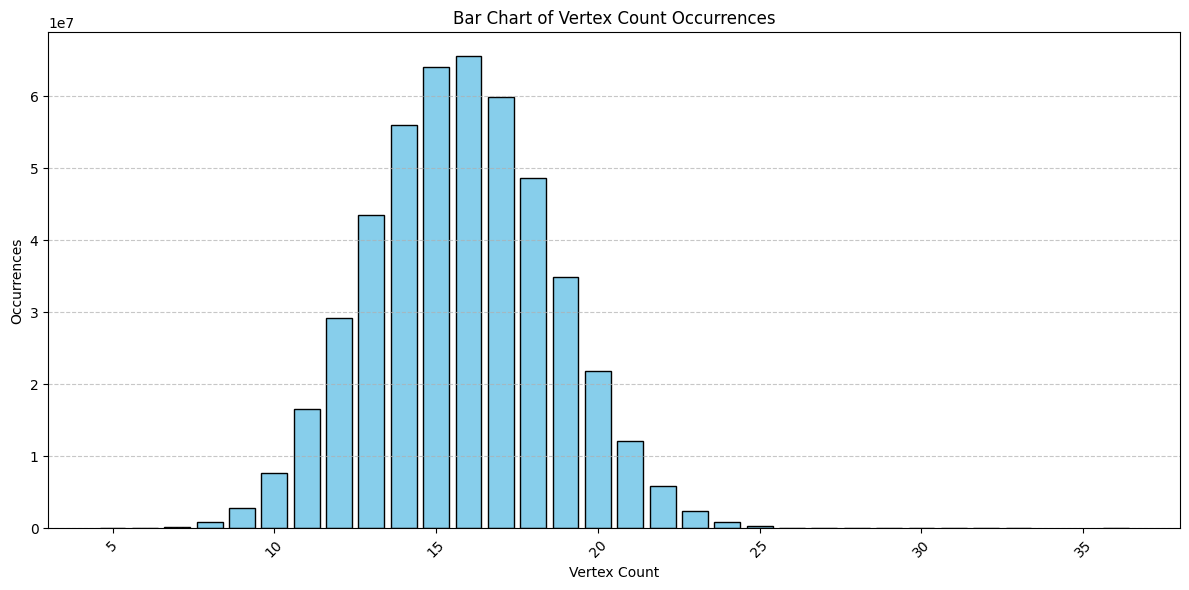

In [17]:
# Plot vertex counts
x = vertex_counts_sorted.index.astype(int)  # Convert indices to integers
y = vertex_counts_sorted.values

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x, y, width=0.8, edgecolor='black', color='skyblue')
plt.xlabel('Vertex Count')
plt.ylabel('Occurrences')
plt.title('Bar Chart of Vertex Count Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
vertexcount_hodge_data = load_dataset(
    "calabi-yau-data/polytopes-4d",
    cache_dir="C:/Users/esultano/git/polytopes/data/huggingface",
    split="full"
).select_columns(["h11", "h12", "vertex_count"])

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

In [4]:
# Filter the dataset for vertex_count between 11 and 21
filtered_data = vertexcount_hodge_data.to_pandas()
filtered_data = filtered_data[(filtered_data["vertex_count"] >= 11) & (filtered_data["vertex_count"] <= 21)]

# Perform stratified sampling (sample 1% from each class)
percentage = 0.01

sampled_data = filtered_data.groupby("vertex_count", group_keys=False).apply(
    lambda x: x.sample(frac=percentage, random_state=42))

# Split into features (X) and target (y)
X = sampled_data[["h11", "h12"]]
y = sampled_data["vertex_count"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Verify distribution after sampling
print("Sampled Class Distribution:")
print(y.value_counts())


C:\Users\esultano\AppData\Local\Temp\ipykernel_31564\3237218724.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Sampled Class Distribution:
vertex_count
16    656159
15    640859
17    599727
14    560606
18    487030
13    434580
19    348478
12    292703
20    219137
11    166084
21    120709
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

          11       0.30      0.04      0.07     49825
          12       0.24      0.06      0.09     87811
          13       0.21      0.10      0.14    130374
          14       0.19      0.19      0.19    168182
          15       0.17      0.26      0.21    192258
          16       0.16      0.30      0.21    196848
          17       0.17      0.24      0.20    179918
          18       0.19      0.15      0.17    146109
          19       0.19      0.10      0.13    104543
          20       0.18      0.02      0.03     65741
          21       0.15      0.00      0.00     36213

    accuracy                           0.18   1357822
   macro avg       0.19      0.13      0.13   1357822
weighted avg       0.19      0.18      0.16   1357822

Feature Importances:
h11    0.512774
h12    0.487226
dtype: float64


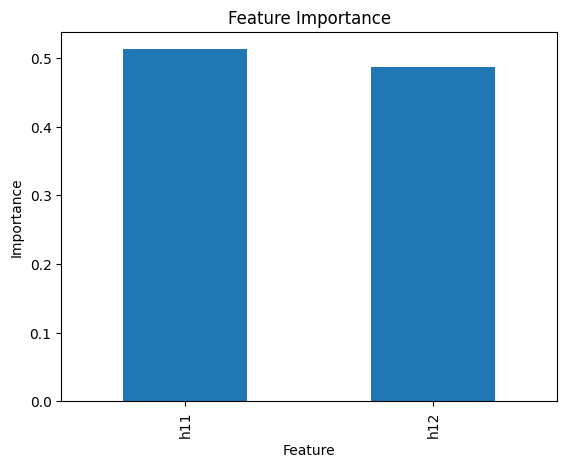

In [5]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("Feature Importances:")
print(feature_importances)

# Visualize feature importance
feature_importances.plot(kind='bar', title='Feature Importance', ylabel='Importance', xlabel='Feature')
plt.show()

Investigate Symmetry

In [6]:
symmetry_data = load_dataset(
    "calabi-yau-data/polytopes-4d",
    cache_dir="C:/Users/esultano/git/polytopes/data/huggingface",
    split="full"
).select_columns(["vertex_count", "point_count", "dual_point_count"])

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

In [12]:
filtered_data = symmetry_data.to_pandas()
#filtered_data = filtered_data[(filtered_data["vertex_count"] >= 11) & (filtered_data["vertex_count"] <= 21)]

# Perform stratified sampling (sample 1% from each class)
percentage = 0.01

sampled_data = filtered_data.groupby("vertex_count", group_keys=False).apply(
    lambda x: x.sample(frac=percentage, random_state=42))


C:\Users\esultano\AppData\Local\Temp\ipykernel_31564\1668402627.py:7: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [13]:
sampled_data['vertex_to_point_ratio'] = sampled_data['vertex_count'] / sampled_data['point_count']
stats = sampled_data['vertex_to_point_ratio'].describe()
print(stats)

count    4.738007e+06
mean     4.155178e-01
std      1.596067e-01
min      1.263158e-02
25%      2.954545e-01
50%      4.054054e-01
75%      5.263158e-01
max      9.615385e-01
Name: vertex_to_point_ratio, dtype: float64


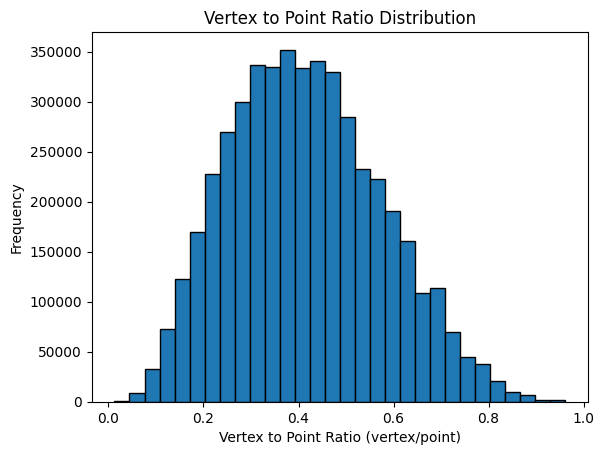

In [8]:
plt.hist(sampled_data['vertex_to_point_ratio'], bins=30, edgecolor='black')
plt.title("Vertex to Point Ratio Distribution")
plt.xlabel("Vertex to Point Ratio (vertex/point)")
plt.ylabel("Frequency")
plt.show()

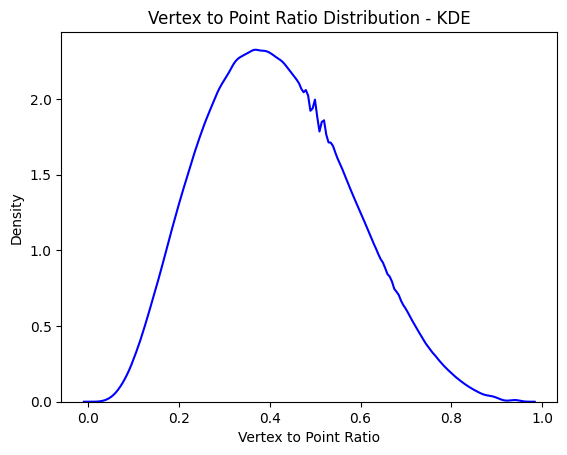

In [9]:
# Plot the KDE for 'symmetry_ratio'
sns.kdeplot(sampled_data['vertex_to_point_ratio'], color='blue')

# Add labels and title
plt.title("Vertex to Point Ratio Distribution - KDE")
plt.xlabel("Vertex to Point Ratio")
plt.ylabel("Density")
plt.show()

C:\Users\esultano\AppData\Local\Temp\ipykernel_31564\3142336592.py:8: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



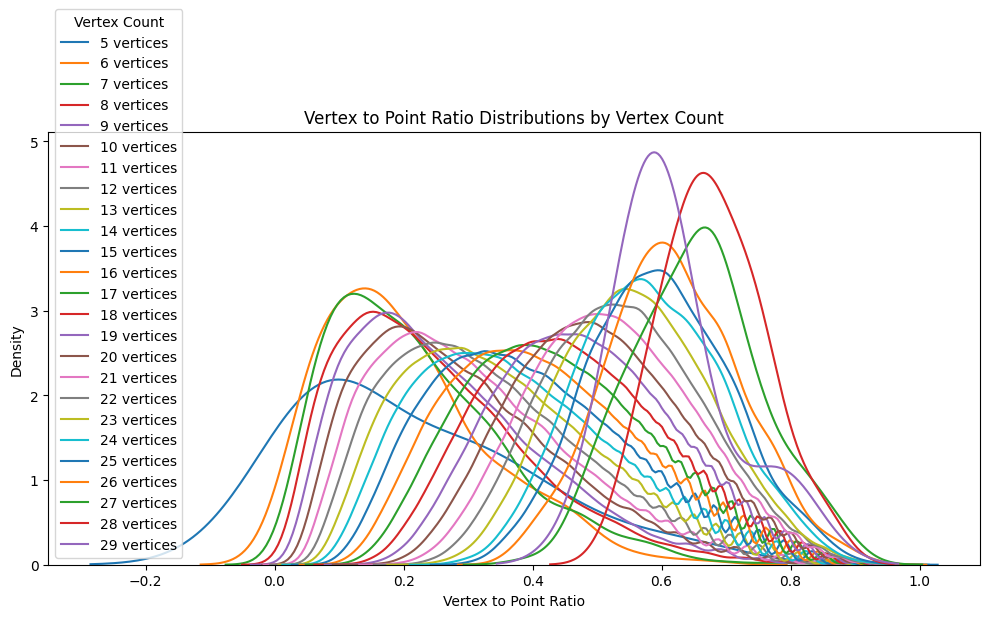

In [21]:
unique_vertex_counts = sampled_data['vertex_count'].unique()

plt.figure(figsize=(10, 6))

# Loop through unique vertex counts and plot distributions
for count in unique_vertex_counts:
    subset = sampled_data[sampled_data['vertex_count'] == count]
    if not subset.empty:  # Avoid empty subsets
        sns.kdeplot(subset['vertex_to_point_ratio'], 
                    label=f'{count} vertices', 
                    linewidth=1.5, 
                    bw_adjust=1.5)  # Adjusted bandwidth to reduce oscillations

plt.title("Vertex to Point Ratio Distributions by Vertex Count")
plt.xlabel("Vertex to Point Ratio")
plt.ylabel("Density")
plt.legend(title="Vertex Count")
plt.tight_layout()
plt.show()

In [15]:
sampled_data['vertex_to_dual_point_ratio'] = sampled_data['vertex_count'] / sampled_data['dual_point_count']
stats = sampled_data['vertex_to_point_ratio'].describe()
print(stats)

count    4.738007e+06
mean     4.155178e-01
std      1.596067e-01
min      1.263158e-02
25%      2.954545e-01
50%      4.054054e-01
75%      5.263158e-01
max      9.615385e-01
Name: vertex_to_point_ratio, dtype: float64


In [17]:
print(sampled_data['vertex_count'].unique())

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]


C:\Users\esultano\AppData\Local\Temp\ipykernel_31564\127616083.py:8: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



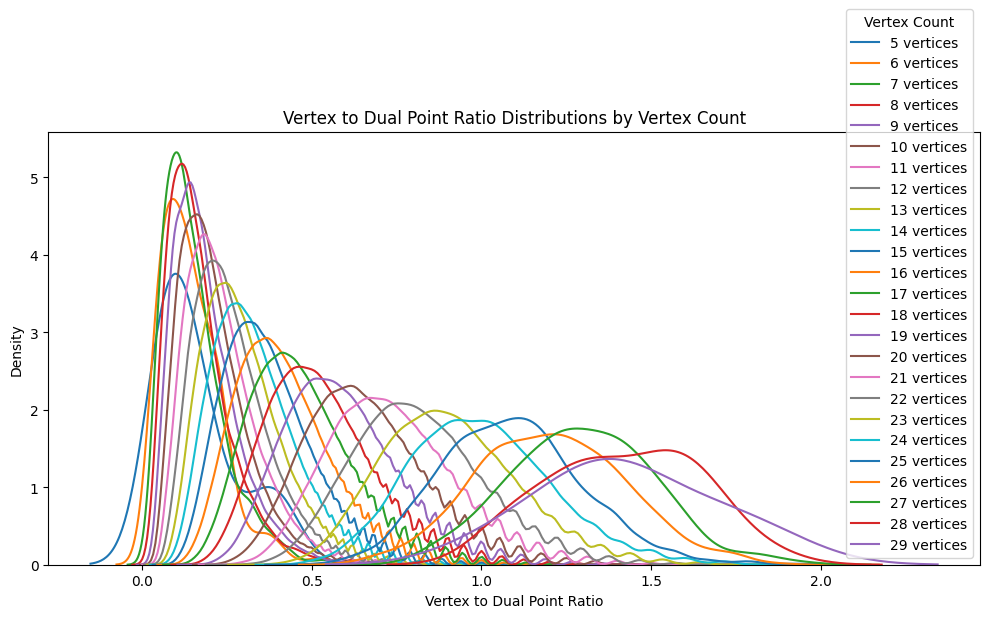

In [22]:
unique_vertex_counts = sampled_data['vertex_count'].unique()

plt.figure(figsize=(10, 6))

# Loop through unique vertex counts and plot distributions
for count in unique_vertex_counts:
    subset = sampled_data[sampled_data['vertex_count'] == count]
    if not subset.empty:  # Avoid empty subsets
        sns.kdeplot(subset['vertex_to_dual_point_ratio'], 
                    label=f'{count} vertices', 
                    linewidth=1.5, 
                    bw_adjust=1.5)  # Adjusted bandwidth to reduce oscillations

plt.title("Vertex to Dual Point Ratio Distributions by Vertex Count")
plt.xlabel("Vertex to Dual Point Ratio")
plt.ylabel("Density")
plt.legend(title="Vertex Count")
plt.tight_layout()
plt.show()

In [16]:
def calculate_hull_volume(vertices):
    vertices = np.vstack(vertices)
    hull = ConvexHull(vertices)
    return hull.volume

df['volume'] = df['vertices'].apply(calculate_hull_volume)

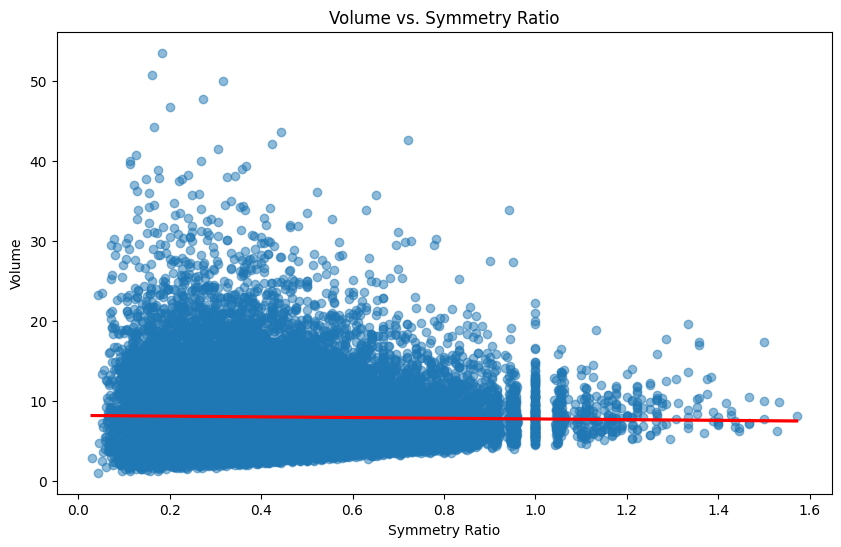

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='symmetry_ratio', y='volume', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title("Volume vs. Symmetry Ratio")
plt.xlabel("Symmetry Ratio")
plt.ylabel("Volume")
plt.show()

C:\Users\esultano\AppData\Local\Temp\ipykernel_13052\1198195103.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



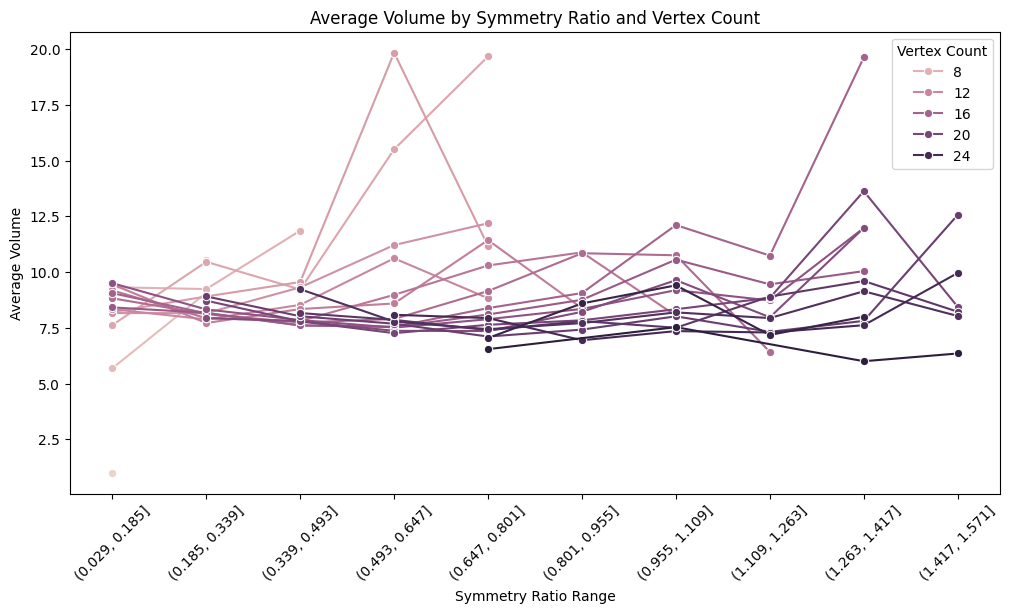

In [30]:
# Group by vertex count and symmetry ratio range
df['symmetry_range'] = pd.cut(df['symmetry_ratio'], bins=10)
grouped = df.groupby(['vertex_count', 'symmetry_range'])['volume'].mean().reset_index()
grouped['symmetry_range'] = grouped['symmetry_range'].astype(str)

# Plot the lineplot with updated symmetry_range format
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='symmetry_range', y='volume', hue='vertex_count', marker="o")
plt.xticks(rotation=45)
plt.title("Average Volume by Symmetry Ratio and Vertex Count")
plt.xlabel("Symmetry Ratio Range")
plt.ylabel("Average Volume")
plt.legend(title="Vertex Count")
plt.show()

In [ ]:
correlation = df['volume'].corr(df['symmetry_ratio'])
print(f"Correlation between Volume and Symmetry Ratio: {correlation:.2f}")

Correlation between Volume and Symmetry Ratio: -0.02


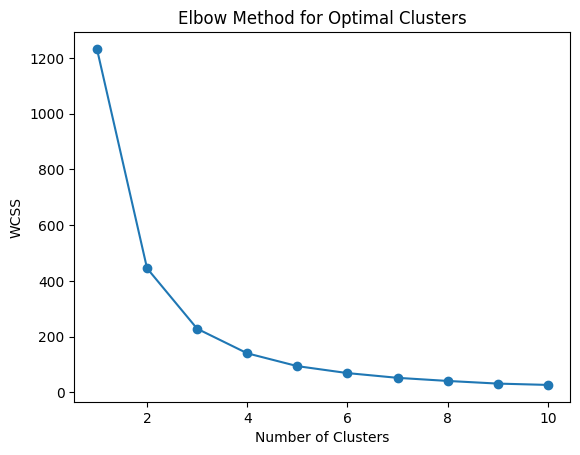

In [ ]:
symmetry_data = df[['symmetry_ratio']].values

# Plot WCSS to find the elbow point
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(symmetry_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['symmetry_cluster'] = kmeans.fit_predict(symmetry_data)

In [ ]:
percentile = 0.99
threshold = df['symmetry_ratio'].quantile(percentile)
df['is_outlier'] = df['symmetry_ratio'] > threshold

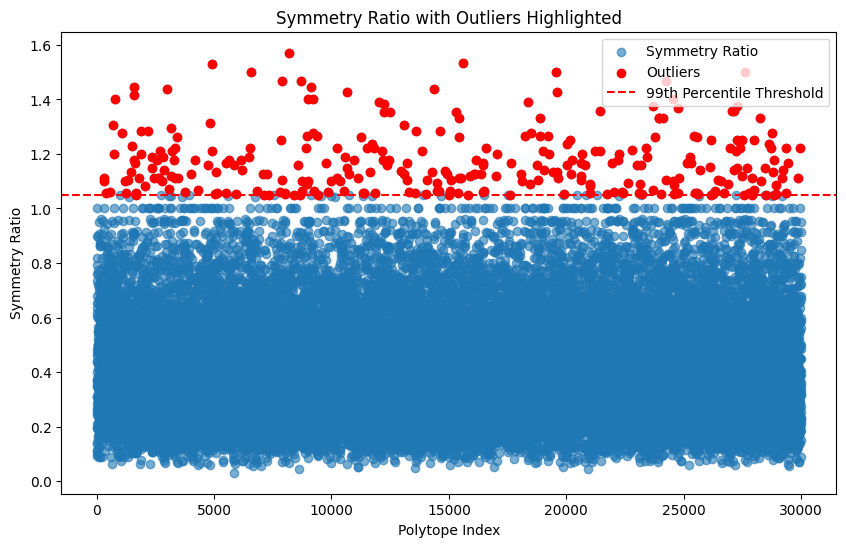

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['symmetry_ratio'], label="Symmetry Ratio", alpha=0.6)
plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']]['symmetry_ratio'], color='red', label="Outliers")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"{int(percentile * 100)}th Percentile Threshold")
plt.title("Symmetry Ratio with Outliers Highlighted")
plt.xlabel("Polytope Index")
plt.ylabel("Symmetry Ratio")
plt.legend()
plt.show()

c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



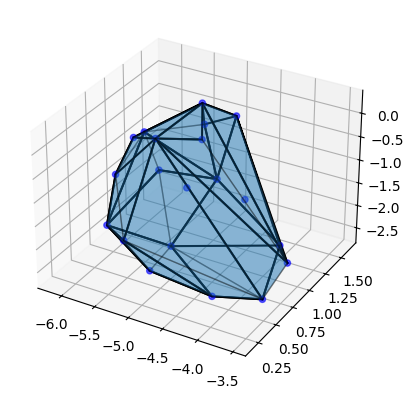

In [ ]:
outliers = df[df['is_outlier']].head(5)

first_outlier = outliers.iloc[0]

vertices_4d = first_outlier['vertices']
vertices_4d = np.vstack(vertices_4d)

#pca = PCA(n_components=3)
#vertices_3d = pca.fit_transform(vertices_4d)
umap = UMAP(n_components=3, random_state=42)
vertices_3d = umap.fit_transform(vertices_4d)

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [ ]:
# see also https://github.com/mwalczyk/polychora?tab=readme-ov-file
# https://arxiv.org/abs/2403.11141
# https://pycddlib.readthedocs.io/en/latest/examples.html#polyhedron-adjacencies-and-incidences

#vertices_4d = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0,-2,1,2],[0,2,-1,-2],[0,0,0,-1],[0,0,-1,0],[0,-1,0,0],[1,-1,1,2],[1,-1,1,0],[0,-2,1,1],[0,-1,1,2],[0,-1,1,0],[0,0,1,1],[-1,0,-1,-1],[-1,1,0,0],[-1,2,-2,-2],[-1,-1,0,0],[-1,2,-1,-1]]

num_verts = vertices_4d.shape[0]
vertices = np.hstack((np.ones((num_verts,1)), vertices_4d))
mat = cdd.matrix_from_array(vertices, rep_type=cdd.RepType.GENERATOR)
poly = cdd.polyhedron_from_matrix(mat)

# get the adjacent vertices of each vertex
adjacencies = [list(x) for x in cdd.matrix_adjacency(mat)]
print(adjacencies)


[[9, 10, 5, 7], [9, 19, 5, 14], [5, 10, 13, 14, 16], [9, 19, 12, 7], [7, 9, 11, 12, 18], [0, 1, 2, 6, 10, 17, 19], [10, 13, 5, 15], [0, 3, 4, 8, 9, 15, 17], [10, 11, 15, 7], [0, 1, 3, 4, 7, 10, 12, 14], [0, 2, 5, 6, 8, 9, 11, 13], [4, 8, 10, 13, 18], [3, 4, 9, 14, 16], [2, 6, 10, 11, 18], [1, 2, 9, 12, 16], [6, 7, 8, 17, 18], [2, 12, 14, 18, 19], [19, 15, 5, 7], [4, 11, 13, 15, 16], [1, 3, 5, 16, 17]]


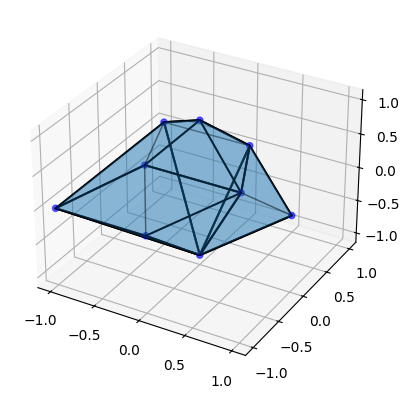

In [ ]:
# Project onto 3D by setting the fourth dimension to a fixed value (e.g., w = 0)
vertices_3d = vertices_4d[vertices_4d[:, 3] == 0][:, :3]  # Slicing at w=0

hull = ConvexHull(vertices_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vertices_3d[:, 0], vertices_3d[:, 1], vertices_3d[:, 2], color='blue', alpha=0.6)

for simplex in hull.simplices:
    points = vertices_3d[simplex]
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-')

faces = Poly3DCollection(vertices_3d[hull.simplices], alpha=0.3, edgecolor='k')
ax.add_collection3d(faces)

plt.show()

In [ ]:
V = np.array(vertices_3d)
print(V)
poly_qhull = pc.qhull(V)
print(pc.volume(poly_qhull))

[[ 1  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [ 0  0 -1]
 [ 0 -1  0]
 [ 1 -1  1]
 [ 0 -1  1]
 [-1  1  0]
 [-1 -1  0]]
1.4533333333333334


Predict the Hodge numbers based on vertex count.

In [ ]:
# Extract features (vertex count) and targets (h11, h12)
X = df[['vertex_count']]
y = df[['h11', 'h12']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a multi-output RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "vertex_count": X_test.values.flatten(),
    "h11_actual": y_test['h11'].values,
    "h11_predicted": y_pred[:, 0],
    "h12_actual": y_test['h12'].values,
    "h12_predicted": y_pred[:, 1]
})
print(predictions.head())

MSE: 219.09, RMSE: 14.78, MAE: 10.89, R²: 0.08
   vertex_count  h11_actual  h11_predicted  h12_actual  h12_predicted
0            18          23      29.660567          24      34.587201
1            15          34      35.928097          56      34.687800
2            17          33      31.418356          67      34.320437
3            19          22      27.704804          23      34.237754
4            14          37      38.088652          29      35.480257


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [ ]:
# Prepare features (Hodge numbers) and target (vertex count)
X = df[['h11', 'h12']]
y = df['vertex_count']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "h11": X_test['h11'].values,
    "h12": X_test['h12'].values,
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred
})
print(predictions.head())

RMSE: 2.46
R^2 Score: 0.20
   h11  h12  vertex_count_actual  vertex_count_predicted
0   23   24                   18               17.926231
1   34   56                   15               15.249679
2   33   67                   17               16.504750
3   22   23                   19               17.353666
4   37   29                   14               15.942201


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Predict the vertex count based on Hodge numbers

In [25]:
X = df[['h11', 'h12']]
y = df['vertex_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Display sample predictions
predictions = pd.DataFrame({
    "h11": X_test['h11'].values,
    "h12": X_test['h12'].values,
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred
})
print(predictions.head())

RMSE: 2.45
R^2 Score: 0.21
   h11  h12  vertex_count_actual  vertex_count_predicted
0   23   24                   18                      17
1   34   56                   15                      15
2   33   67                   17                      15
3   22   23                   19                      17
4   37   29                   14                      16


c:\Users\esultano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



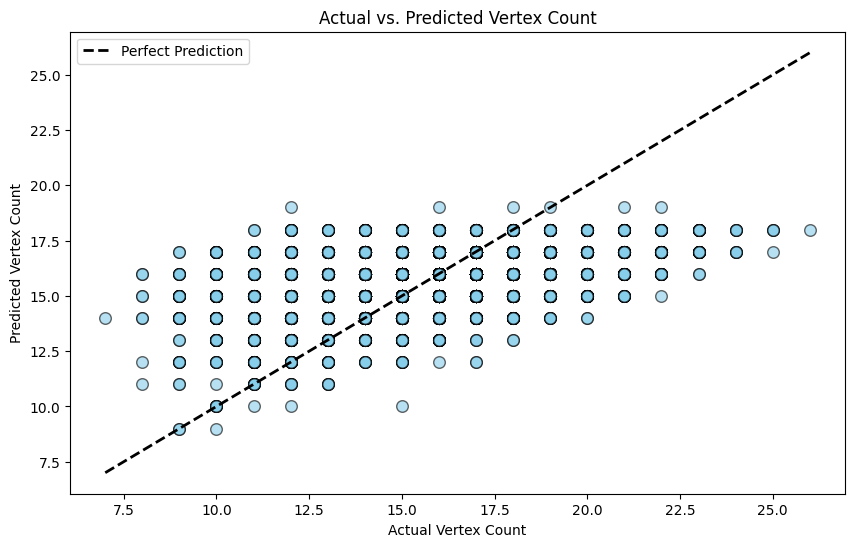

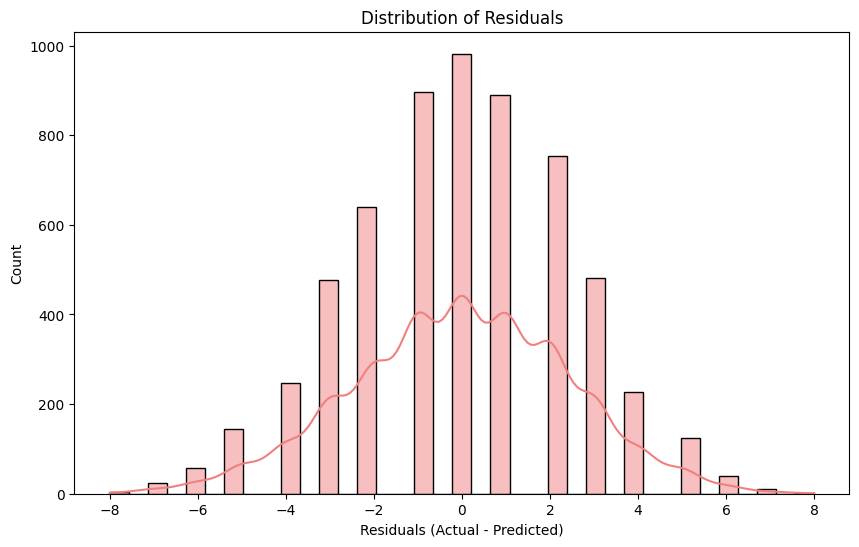

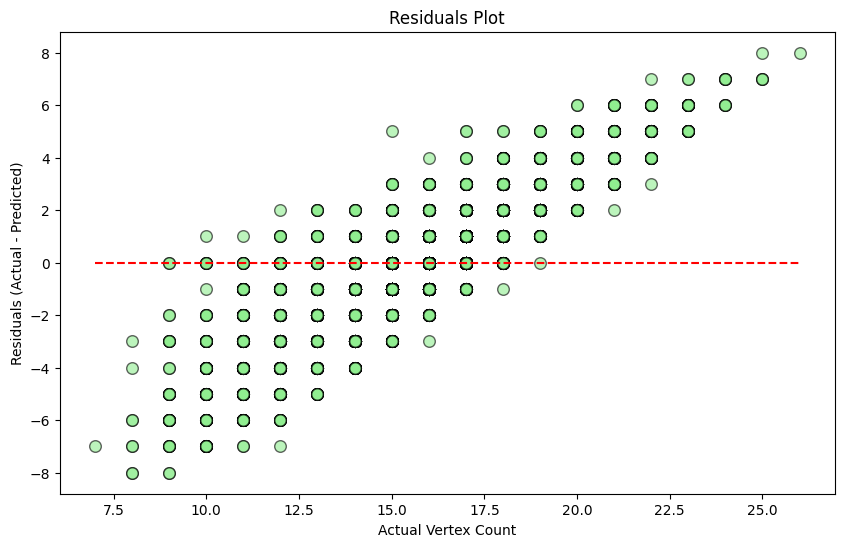

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="skyblue", edgecolor="black", s=70)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual Vertex Count")
plt.ylabel("Predicted Vertex Count")
plt.title("Actual vs. Predicted Vertex Count")
plt.legend()
plt.show()

# Residual plot (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="lightcoral", edgecolor="black")
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.show()

# Scatter plot of residuals to see patterns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6, color="lightgreen", edgecolor="black", s=70)
plt.hlines(0, y_test.min(), y_test.max(), colors="red", linestyles="dashed")
plt.xlabel("Actual Vertex Count")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals Plot")
plt.show()

    vertex_count_actual  mean_absolute_error  median_absolute_error
9                    16             0.895858                    1.0
8                    15             1.041916                    1.0
10                   17             1.090216                    1.0
7                    14             1.485714                    1.0
11                   18             1.783276                    2.0
6                    13             2.207940                    2.0
12                   19             2.516355                    2.0
5                    12             2.979328                    3.0
13                   20             3.303887                    3.0
4                    11             3.511111                    4.0


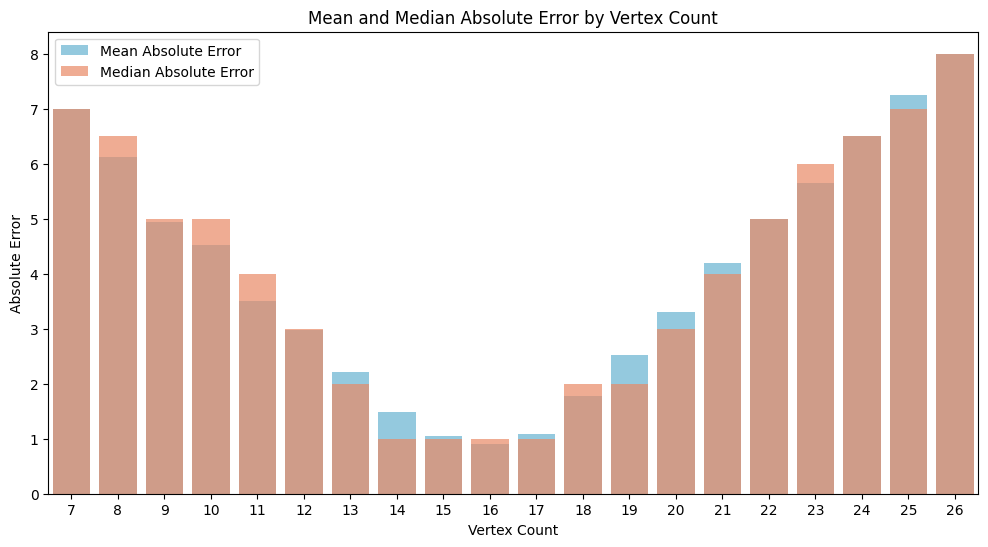

In [28]:
# Calculate absolute errors
errors = np.abs(y_test.values - y_pred)

# Create a DataFrame with actual, predicted, and errors
results_df = pd.DataFrame({
    "vertex_count_actual": y_test.values,
    "vertex_count_predicted": y_pred,
    "absolute_error": errors
})

# Group by actual vertex count and calculate mean and median absolute error
error_summary = results_df.groupby("vertex_count_actual")["absolute_error"].agg(["mean", "median"]).reset_index()
error_summary = error_summary.rename(columns={"mean": "mean_absolute_error", "median": "median_absolute_error"})

# Sort by mean absolute error to see which counts are best predicted
error_summary_sorted = error_summary.sort_values(by="mean_absolute_error")
print(error_summary_sorted.head(10))  # Display top 10 vertex counts with lowest mean error

# Plot the mean and median absolute errors
plt.figure(figsize=(12, 6))
sns.barplot(data=error_summary_sorted, x="vertex_count_actual", y="mean_absolute_error", color="skyblue", label="Mean Absolute Error")
sns.barplot(data=error_summary_sorted, x="vertex_count_actual", y="median_absolute_error", color="coral", alpha=0.7, label="Median Absolute Error")
plt.xlabel("Vertex Count")
plt.ylabel("Absolute Error")
plt.title("Mean and Median Absolute Error by Vertex Count")
plt.legend()
plt.show()